In [414]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import identify_nominal_columns
from geopy import distance

from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from xgboost import XGBRegressor, plot_importance
import xgboost as xgb
import joblib

from utils import preprocess

In [415]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [416]:
DATA_DIR = './data/'
IMG_DIR = './img/'
PROCESSED_DATA_DIR = './processed_data/'
TRAIN_FILE = DATA_DIR + 'train.csv'
TEST_FILE = DATA_DIR + 'test.csv'
PROCESSED_TRAIN_FILE = PROCESSED_DATA_DIR + 'processed_train.csv'
PROCESSED_TEST_FILE = PROCESSED_DATA_DIR + 'processed_test.csv'
AUX_DATA_DIR = DATA_DIR + 'auxiliary-data/'
SUBZONE_FILE = AUX_DATA_DIR + 'sg-subzones.csv'

COMC = AUX_DATA_DIR + 'sg-commerical-centres.csv'
MRT = AUX_DATA_DIR + 'sg-mrt-stations.csv'
PSCHOOL = AUX_DATA_DIR + 'sg-primary-schools.csv'
SSCHOOL = AUX_DATA_DIR + 'sg-secondary-schools.csv'
MALL = AUX_DATA_DIR + 'sg-shopping-malls.csv'

mrt_station = pd.read_csv(MRT)
comc = pd.read_csv(COMC)
pschool = pd.read_csv(PSCHOOL)
sschool = pd.read_csv(SSCHOOL)
mall = pd.read_csv(MALL)

## XGBOOST

## 1 Load preprocessed data

In [397]:
df = pd.read_csv(PROCESSED_TRAIN_FILE)

In [398]:
columns_pa = df.filter(like='pa_').columns
columns_pt = df.filter(like='pt_').columns

In [399]:
#features_drop = ['lat', 'lng']
#df_train = df.drop(features_drop, axis=1)
df_train = df.copy()

In [400]:
df_train.drop(columns_pa, axis = 1, inplace=True)
#df_train.drop(columns_pt, axis = 1, inplace=True)

X_train_all = df_train.drop('price', axis=1)
y_train_all = df_train['price']

In [401]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20153 entries, 0 to 20152
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tenure                          20153 non-null  float64
 1   built_year                      20153 non-null  float64
 2   num_beds                        20153 non-null  float64
 3   num_baths                       20153 non-null  float64
 4   size_sqft                       20153 non-null  float64
 5   lat                             20153 non-null  float64
 6   lng                             20153 non-null  float64
 7   subzone_property_type_encoding  20153 non-null  float64
 8   num_cc_5km                      20153 non-null  int64  
 9   num_mrt_800m                    20153 non-null  int64  
 10  nearest_mrt_km                  20153 non-null  float64
 11  num_ps_1km                      20153 non-null  int64  
 12  num_ps_1km_to_2km               

## 2 model training

### 2.1 intuition to use XGBoost algorithm

In [402]:
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state= 10)

y_train = X_train['price']
X_train.drop('price', axis=1, inplace=True)
y_test = X_test['price']
X_test.drop('price', axis=1, inplace=True)

In [403]:
# create model instance
xgb1 = XGBRegressor()
# fit model
xgb1.fit(X_train, y_train)
# make predictions
y_hat_train = xgb1.predict(X_train)
y_hat_test = xgb1.predict(X_test)

# Save model into JSON format.
#reg.save_model("regressor.json")

In [404]:
print(
    f' RMSE of XGBoost: \n {mean_squared_error(y_train, y_hat_train, squared=False)} (Train) \
    \n {mean_squared_error(y_test, y_hat_test, squared=False)} (Test)'
)

 RMSE of XGBoost: 
 399273.80010871385 (Train)     
 1273493.324862523 (Test)


### 2.2 hyper-parameters tuning

* issue: the RMSE between training prediction and validation prediction varies apparently, which refers to a Over-fitting Problem.
* target: improve RMSE of validation set and try to address overfitting problem (trade-off between bias and variance)
    * **colsample_bytree**: Represents the fraction of columns to be randomly sampled for each tree. It might improve overfittin
    * **subsample**: Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting.
    * **lambda (Regulation parameter)** : L2 regularization on the weights (Ridge Regression). It might help to reduce overfitting.
    * **feature sampling** : Use planning_area, protery_type, subzone_encoding, auxiliary data or not.


Considering tuning xgboost model for all hyper parameters and feature subsets is time consuing and impractical, our group firstly utilise a **RandomizedSearchCV** method to speed up and grasp the first view of our model and data. Then with RMSE result, we choose a more specific range for hyperparameter tuning and decide what features to use for the following gridsearchCV section.

In [395]:
params = { 'max_depth': [3, 5, 10],
           'learning_rate': [0.1, 0.3],
           'subsample': [0.5, 0.6, 0.7, 0.8, 1],
           'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1],
           'n_estimators': [50, 100, 500],
          'reg_lambda': [0, 0.1, 0.3]
         }

xgbr = xgb.XGBRegressor(random_state= 20)
kf = KFold(n_splits=5, random_state= 28, shuffle=True)

reg = RandomizedSearchCV(estimator=xgbr, 
                         param_distributions=params,
                         cv=kf,
                         scoring='neg_mean_squared_error', 
                         # random_state= 30,
                         verbose=1)

reg.fit(X_train_all, y_train_all)


print('input data size:', X_train_all.shape)
print("Best parameters:", reg.best_params_)
print("Lowest RMSE: ", (-reg.best_score_)**(1/2.0))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'subsample': 0.7, 'reg_lambda': 0.3, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Lowest RMSE:  1745194.8073565094


In [411]:
## GridSearchCV to make a exhaustive test for the potential useful combination
params = { 'max_depth': [5],
           'learning_rate': [0.1, 0.3],
           'subsample': [0.8, 1],
           'colsample_bytree': [0.6, 1],
           'n_estimators': [100, 500],
           'reg_lambda': [0, 0.3]
         }

xgbr = xgb.XGBRegressor(random_state= 20)
kf = KFold(n_splits=5, random_state= 20, shuffle=True)

reg = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   cv=kf,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

reg.fit(X_train_all, y_train_all)

# joblib.dump(reg, 'xgb_model.pkl')

print("Best parameters:", reg.best_params_)
print("Lowest RMSE: ", (-reg.best_score_)**(1/2.0))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 800, 'reg_lambda': 0.3, 'subsample': 0.8}
Lowest RMSE:  1575028.1315797274


In [412]:
joblib.dump(reg, 'xgb_model2.pkl')

['xgb_model2.pkl']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

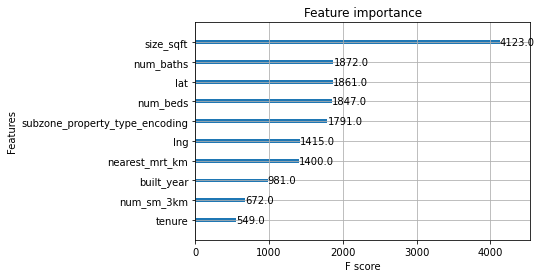

In [413]:
plot_importance(reg.best_estimator_, max_num_features= 10)

## 3 evaluation
* Explore and visualize the performance of different hyperparameters suppressing over-fitting issue on this dataset

In [417]:
X_eval = df.drop('price', axis=1)
y_eval = df['price']

In [421]:
## subsample ratio
values_ss = np.array([0.5, 0.6, 0.7, 0.8, 0.9 ,1.0])

params = { 'max_depth': [5],
           'learning_rate': [0.1],
           'subsample': values_ss,
           'n_estimators': [500],
         }

xgbr = xgb.XGBRegressor(random_state= 20)
kf = KFold(n_splits=5, random_state= 20, shuffle=True)

reg_subsample = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   cv=kf,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

reg_subsample.fit(X_eval, y_eval)

# joblib.dump(reg_subsample, 'xgb_subsample.pkl')

print("Best parameters:", reg_subsample.best_params_)
print("Lowest RMSE: ", (-reg_subsample.best_score_)**(1/2.0))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.7999999999999999}
Lowest RMSE:  1653701.5500941635


In [500]:
## colsample_bytree ratio
values_cs = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ,1.0])

params = { 'max_depth': [5],
           'learning_rate': [0.1],
           'colsample_bytree': values_cs,
           'n_estimators': [500],
         }

xgbr = xgb.XGBRegressor(random_state= 20)
kf = KFold(n_splits=5, random_state= 20, shuffle=True)

reg_colsample = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   cv=kf,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

reg_colsample.fit(X_eval, y_eval)

# joblib.dump(reg_colsample, 'xgb_colsample.pkl')

print("Best parameters:", reg_colsample.best_params_)
print("Lowest RMSE: ", (-reg_colsample.best_score_)**(1/2.0))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Lowest RMSE:  1605746.5287007655


In [504]:
## lambda of 2-norm in loss function
values_lambda = np.array([0, 0.1, 0.2, 0.3, 0.4])

params = { 'max_depth': [5],
           'learning_rate': [0.1],
           'reg_lambda': values_lambda,
           'n_estimators': [500],
         }

xgbr = xgb.XGBRegressor(random_state= 20)
kf = KFold(n_splits=5, random_state= 20, shuffle=True)

reg_lambda = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   cv=kf,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

reg_lambda.fit(X_eval, y_eval)

# joblib.dump(reg_lambda, 'xgb_lambda.pkl')

print("Best parameters:", reg_lambda.best_params_)
print("Lowest RMSE: ", (-reg_lambda.best_score_)**(1/2.0))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 0.2}
Lowest RMSE:  1584239.608035902


Text(0.5, 0, 'lambda ratio')

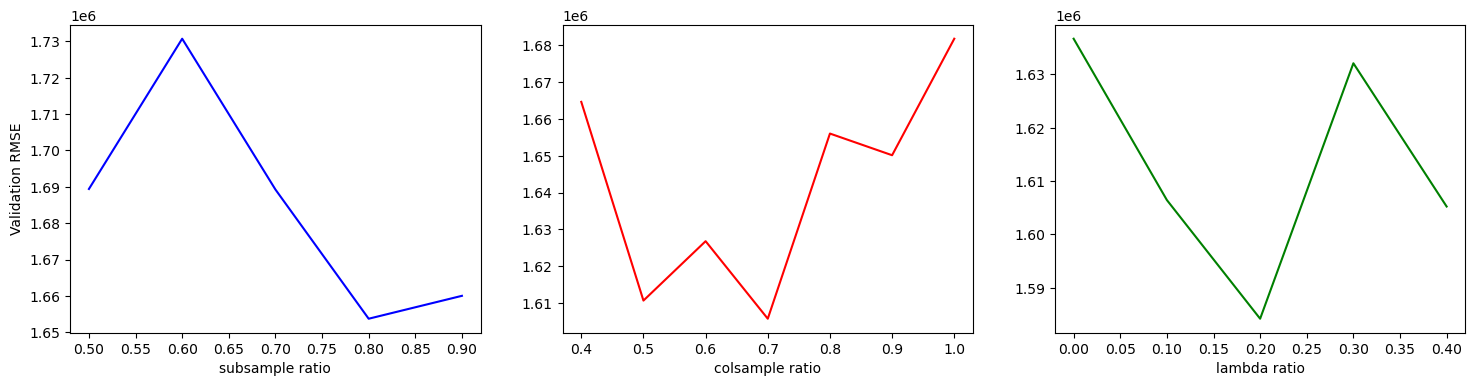

In [501]:
# plot
plt.figure(figsize=(18,4))

ax1=plt.subplot(1,3,1)  #新建左上1号子窗口
ax1.plot(values_ss ,(np.sqrt(-reg_subsample.cv_results_['mean_test_score'])),'b')
ax1.set_xlabel('subsample ratio')
ax1.set_ylabel('Validation RMSE')

ax1=plt.subplot(1,3,2)  #新建左上1号子窗口
ax1.plot(values_cs ,(np.sqrt(-reg_colsample.cv_results_['mean_test_score'])),'r')
ax1.set_xlabel('colsample ratio')

ax1=plt.subplot(1,3,3)  #新建左上1号子窗口
ax1.plot(values_lambda ,(np.sqrt(-reg_lambda.cv_results_['mean_test_score'])),'g')
ax1.set_xlabel('lambda ratio')

## 4 prediction

In [424]:
test_set = pd.read_csv(PROCESSED_TEST_FILE)

# features_drop = ['lat', 'lng', 'nearest_mrt_km']

df_test = test_set.copy()

df_test.drop(columns_pa, axis=1, inplace=True)
# df_test.drop(columns_pt, axis=1, inplace=True)

model = joblib.load('xgb_model2.pkl')

output = pd.read_csv('./example-submission.csv')
output["Predicted"] = model.predict(df_test)
output.to_csv('xgb_submission2.csv', index=False)

In [502]:
## return test prediction with models in the evaluation part
test_set = pd.read_csv(PROCESSED_TEST_FILE)
df_test2 = test_set

output = pd.read_csv('./example-submission.csv')
output["Predicted"] = reg_colsample.best_estimator_.predict(df_test2)
output.to_csv('xgb_submission2.csv', index=False)